# Forecasting total system-level demand in the next hour

## possible feature that correlate with bike demand
  1. weather
  1. type of user 
  1. weekday
  1. season
  1. time of day
  1. location
  

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import datetime

%matplotlib inline

In [12]:
df = pd.read_csv("../may_data.csv", parse_dates=["start_time","end_time"])
df.head()

,Unnamed: 0,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type,month
0,628548,2016-05-31 23:57:00,2016-06-01 00:14:00,22,282,May St & Taylor St,Halsted St & Maxwell St,609,Subscriber,5
1,628549,2016-05-31 23:57:00,2016-06-01 00:14:00,22,282,May St & Taylor St,Halsted St & Maxwell St,1207,Subscriber,5
2,628550,2016-05-31 23:56:00,2016-06-01 00:15:00,90,320,Millennium Park,Loomis St & Lexington St,4369,Subscriber,5
3,628551,2016-05-31 23:55:00,2016-06-01 00:18:00,174,273,Canal St & Madison St,Michigan Ave & 18th St,2703,Subscriber,5
4,628552,2016-05-31 23:55:00,2016-06-01 00:14:00,90,22,Millennium Park,May St & Taylor St,3828,Subscriber,5


In [13]:
# hinzufügen der Dauer der Fahrt
df["duration"] = (df["end_time"] - df["start_time"]).astype("timedelta64[m]")
df.head()

,Unnamed: 0,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type,month,duration
0,628548,2016-05-31 23:57:00,2016-06-01 00:14:00,22,282,May St & Taylor St,Halsted St & Maxwell St,609,Subscriber,5,17.0
1,628549,2016-05-31 23:57:00,2016-06-01 00:14:00,22,282,May St & Taylor St,Halsted St & Maxwell St,1207,Subscriber,5,17.0
2,628550,2016-05-31 23:56:00,2016-06-01 00:15:00,90,320,Millennium Park,Loomis St & Lexington St,4369,Subscriber,5,19.0
3,628551,2016-05-31 23:55:00,2016-06-01 00:18:00,174,273,Canal St & Madison St,Michigan Ave & 18th St,2703,Subscriber,5,23.0
4,628552,2016-05-31 23:55:00,2016-06-01 00:14:00,90,22,Millennium Park,May St & Taylor St,3828,Subscriber,5,19.0


In [14]:
# hinzufügen der Wetterdaten
weather = pd.read_csv("../weather_hourly_chicago.csv", parse_dates = ["date_time"])
weather = weather.dropna()
weather["hour"] = weather["date_time"].apply(lambda x:x.hour)
weather["day"] = weather["date_time"].apply(lambda x:x.day)
weather.sort_values(by="date_time")
weather.head()

,date_time,max_temp,min_temp,precip,hour,day
0,2015-01-02 01:00:00,-1.7,-1.7,0.0,1,2
1,2015-01-02 02:00:00,-2.2,-2.2,0.0,2,2
2,2015-01-02 03:00:00,-2.8,-2.8,0.0,3,2
3,2015-01-02 04:00:00,-3.3,-3.3,0.0,4,2
4,2015-01-02 05:00:00,-4.4,-4.4,0.0,5,2


In [15]:
# verbinden mit den Fahrraddaten
df["day"] = df["start_time"].apply(lambda x: x.day)
df['start_hour']= df["start_time"].apply(lambda x: x.hour)
df = df.merge(weather[["max_temp","min_temp","precip","hour","day"]],left_on=["day","start_hour"],right_on=["day","hour"])


In [16]:
df.head()

,Unnamed: 0,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type,month,duration,day,start_hour,max_temp,min_temp,precip,hour
0,628548,2016-05-31 23:57:00,2016-06-01 00:14:00,22,282,May St & Taylor St,Halsted St & Maxwell St,609,Subscriber,5,17.0,31,23,1.7,1.7,0.0,23
1,628548,2016-05-31 23:57:00,2016-06-01 00:14:00,22,282,May St & Taylor St,Halsted St & Maxwell St,609,Subscriber,5,17.0,31,23,13.9,13.9,0.0,23
2,628548,2016-05-31 23:57:00,2016-06-01 00:14:00,22,282,May St & Taylor St,Halsted St & Maxwell St,609,Subscriber,5,17.0,31,23,11.7,11.7,0.0,23
3,628548,2016-05-31 23:57:00,2016-06-01 00:14:00,22,282,May St & Taylor St,Halsted St & Maxwell St,609,Subscriber,5,17.0,31,23,28.9,28.9,0.0,23
4,628548,2016-05-31 23:57:00,2016-06-01 00:14:00,22,282,May St & Taylor St,Halsted St & Maxwell St,609,Subscriber,5,17.0,31,23,28.9,28.9,0.0,23


In [17]:
df.drop(['end_time', 'end_station_id', "start_station_name", "end_station_name" ,"user_type", "hour"], axis=1, inplace=True)
df.head()

,Unnamed: 0,start_time,start_station_id,bike_id,month,duration,day,start_hour,max_temp,min_temp,precip
0,628548,2016-05-31 23:57:00,22,609,5,17.0,31,23,1.7,1.7,0.0
1,628548,2016-05-31 23:57:00,22,609,5,17.0,31,23,13.9,13.9,0.0
2,628548,2016-05-31 23:57:00,22,609,5,17.0,31,23,11.7,11.7,0.0
3,628548,2016-05-31 23:57:00,22,609,5,17.0,31,23,28.9,28.9,0.0
4,628548,2016-05-31 23:57:00,22,609,5,17.0,31,23,28.9,28.9,0.0


In [19]:
# aggregate to trips
feature_data = df.resample("H",on="start_time").agg({"start_station_id":"mean","month":"mean","duration":"mean","start_hour":"mean","day":"mean","max_temp":"mean","min_temp":"mean","precip":"mean","bike_id":"count"})
feature_data.rename(columns={"bike_id":"trips"},inplace=True)
feature_data.head()

,start_station_id,month,duration,start_hour,day,max_temp,min_temp,precip,trips
start_time,,,,,,,,,
2016-05-01 00:00:00,187.440000,5.0,8.840000,0.0,1.0,10.989231,10.926154,0.153846,1625
2016-05-01 01:00:00,220.157895,5.0,9.263158,1.0,1.0,11.740984,11.614754,0.081967,1159
2016-05-01 02:00:00,230.700000,5.0,9.900000,2.0,1.0,9.858065,9.787097,0.161290,1240
2016-05-01 03:00:00,214.500000,5.0,9.200000,3.0,1.0,10.725000,10.664286,0.107143,560
2016-05-01 04:00:00,204.666667,5.0,4.333333,4.0,1.0,9.080328,9.042623,0.180328,183


In [37]:

# hinzufügen des Wochentags
feature_data['start_time']= feature_data.index
feature_data['weekday']= feature_data["start_time"].apply(lambda x: x.weekday())
# hinzufügen des Monats
feature_data['month']= feature_data["start_time"].apply(lambda x: x.month)

In [39]:
# Methode für die Tageszeit
def get_time_of_day(x):
    if(x >= 6 and x <10):
        return "Morning"
    elif(x >= 10 and x <12):
        return "Mid-morning"
    elif(x >= 12 and x <14):
        return "Noon"
    elif(x >= 14 and x <17):
        return "Afternoon"
    elif(x >= 17 and x <21):
        return "Evening"
    else:
        return "Night"
    # hinzufügen der Tageszeit
feature_data["time_of_day"] = feature_data["start_hour"].apply(lambda x: get_time_of_day(x))
feature_data.head()

,start_station_id,month,duration,start_hour,day,max_temp,min_temp,precip,trips,start_time,weekday,time_of_day
start_time,,,,,,,,,,,,
2016-05-01 00:00:00,187.440000,5,8.840000,0.0,1.0,10.989231,10.926154,0.153846,1625,2016-05-01 00:00:00,6,Night
2016-05-01 01:00:00,220.157895,5,9.263158,1.0,1.0,11.740984,11.614754,0.081967,1159,2016-05-01 01:00:00,6,Night
2016-05-01 02:00:00,230.700000,5,9.900000,2.0,1.0,9.858065,9.787097,0.161290,1240,2016-05-01 02:00:00,6,Night
2016-05-01 03:00:00,214.500000,5,9.200000,3.0,1.0,10.725000,10.664286,0.107143,560,2016-05-01 03:00:00,6,Night
2016-05-01 04:00:00,204.666667,5,4.333333,4.0,1.0,9.080328,9.042623,0.180328,183,2016-05-01 04:00:00,6,Night


In [40]:
# hinzufügen der Season
def get_season(x):
    if(x == 1 or x == 2 or x == 12):
        return "Winter"
    elif(x >= 3 and x <= 5):
        return "Spring"
    elif(x >= 6 and x <= 8):
        return "Sommer"
    else:
        return "Autumn"

feature_data["season"] = feature_data["month"].apply(lambda x: get_season(x))
feature_data.head(3)

,start_station_id,month,duration,start_hour,day,max_temp,min_temp,precip,trips,start_time,weekday,time_of_day,season
start_time,,,,,,,,,,,,,
2016-05-01 00:00:00,187.440000,5,8.840000,0.0,1.0,10.989231,10.926154,0.153846,1625,2016-05-01 00:00:00,6,Night,Spring
2016-05-01 01:00:00,220.157895,5,9.263158,1.0,1.0,11.740984,11.614754,0.081967,1159,2016-05-01 01:00:00,6,Night,Spring
2016-05-01 02:00:00,230.700000,5,9.900000,2.0,1.0,9.858065,9.787097,0.161290,1240,2016-05-01 02:00:00,6,Night,Spring


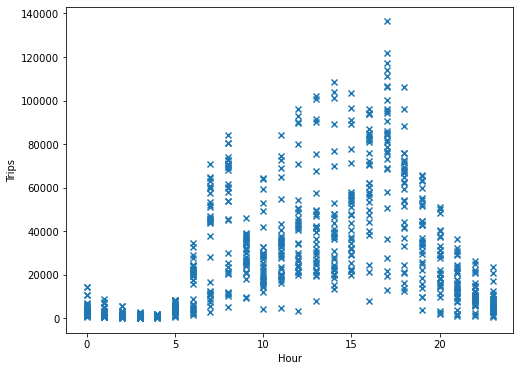

In [44]:
fig, ax = plt.subplots(figsize = (8,6))
# Plotting the data
ax.scatter( feature_data["start_hour"], feature_data["trips"],marker='x',)
ax.set_xlabel("Hour")
ax.set_ylabel("Trips")

plt.show()

In [56]:
from sklearn.preprocessing import PolynomialFeatures

In [57]:
def plot_regression_poly_scikit(X,Y,d):
    
    # initialize PolynomialFeatures
    poly_reg = PolynomialFeatures (degree = d)
    
    # Polynomial transformation
    x_poly = poly_reg.fit_transform(X.reshape(-1,1))
    
    # Fitting linear regression to polynomial features
    lin_reg_Poly = LinearRegression()
    lin_reg_Poly.fit(x_poly, Y)
    model_pred = lin_reg_Poly.predict(x_poly)
    
    # Plotting the regression line and the data (we have to transform the inputs as well!)
    x_fit = np.arange(X.min(),X.max() ,1)[:, np.newaxis]
    y_pred = lin_reg_Poly.predict(poly_reg.fit_transform(x_fit.reshape(-1,1)))
    
    plt.figure(figsize = (8,6))
    plt.scatter(X,Y,marker="x", c='C2')
    ylim = plt.ylim()
    plt.plot(x_fit,y_pred, c='C1')
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Demand (GW)")
    plt.xlim([X.min()-2,X.max()+2]) # leave some space before and after limits
    plt.ylim(ylim)
    print ('The R^2 for quadratic curve is: ',r2_score(Y, model_pred))
    #print(lin_reg_Poly.coef_)

In [63]:
x = feature_data["start_hour"].fillna(0)
y = feature_data["trips"].fillna(0)
x = x.values
y = y.values

The R^2 for quadratic curve is:  0.39773361766114224


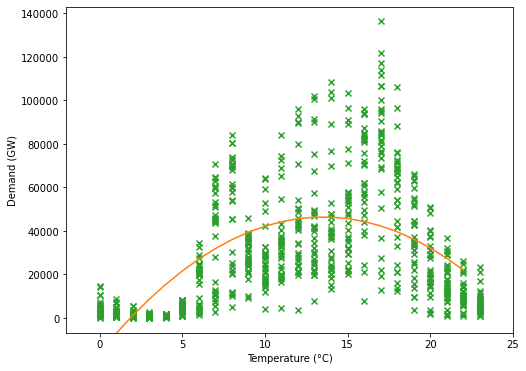

In [66]:
plot_regression_poly_scikit(X = x, Y =y, d = 2)

The R^2 for quadratic curve is:  0.49616549329911663


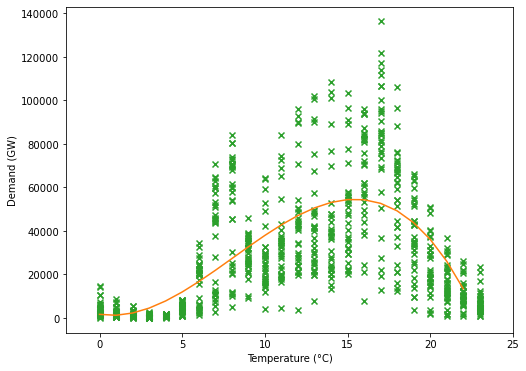

In [67]:
plot_regression_poly_scikit(X = x, Y =y, d = 3)

The R^2 for quadratic curve is:  0.4968689858306746


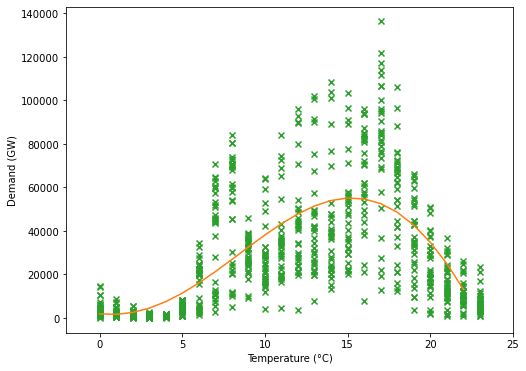

In [69]:
plot_regression_poly_scikit(X = x, Y =y, d = 5)

The R^2 for quadratic curve is:  0.5353077034097625


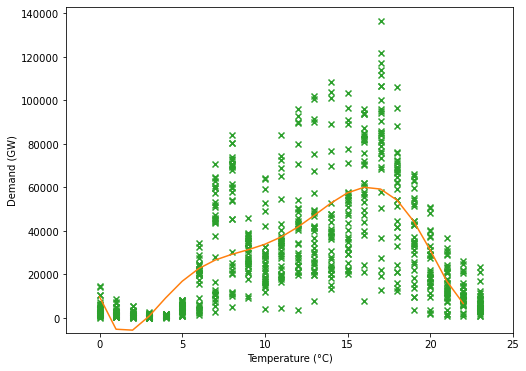

In [70]:
plot_regression_poly_scikit(X = x, Y =y, d = 6)

The R^2 for quadratic curve is:  0.550219085030718


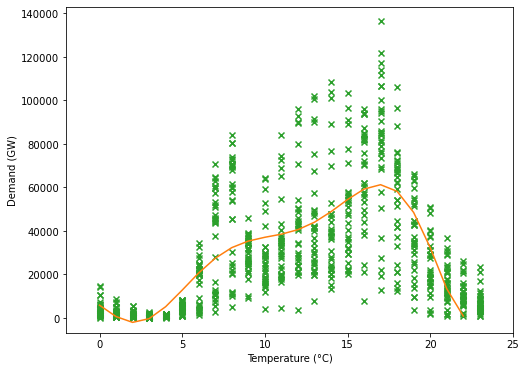

In [71]:
plot_regression_poly_scikit(X = x, Y =y, d = 7)

The R^2 for quadratic curve is:  0.4456133510507073


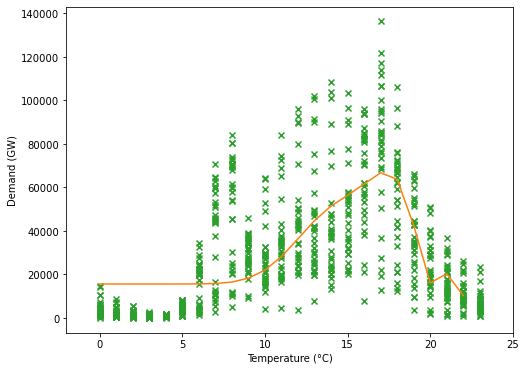

In [72]:
plot_regression_poly_scikit(X = x, Y =y, d = 20)

The R^2 for quadratic curve is:  0.5807609414622876


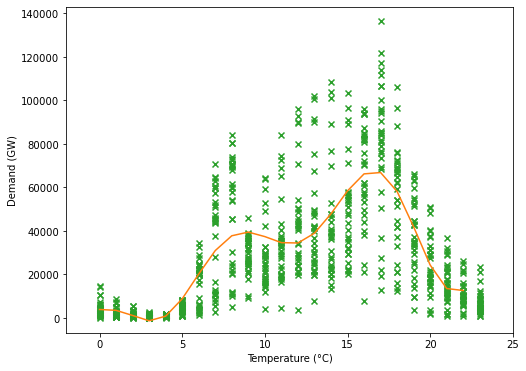

In [73]:
plot_regression_poly_scikit(X = x, Y =y, d = 10)

The R^2 for quadratic curve is:  0.5809314459185795


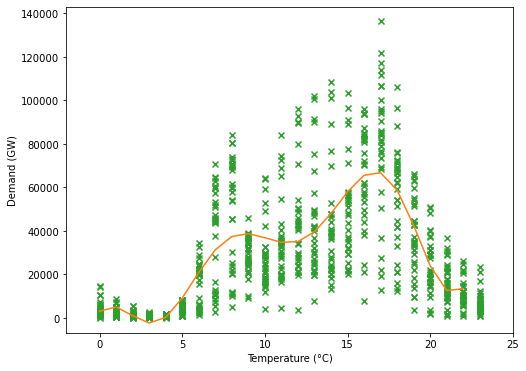

In [77]:
plot_regression_poly_scikit(X = x, Y =y, d = 11)

The R^2 for quadratic curve is:  0.5800422579688915


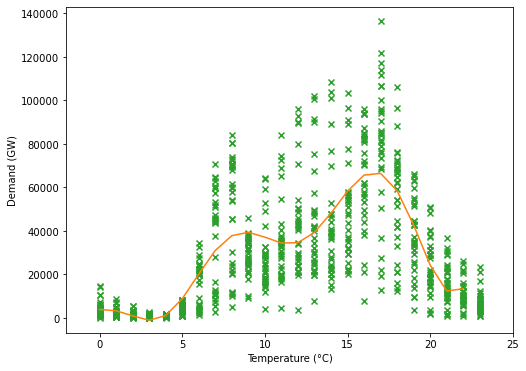

In [78]:
plot_regression_poly_scikit(X = x, Y =y, d = 12)

d = 11 -> R^2 am höchsten

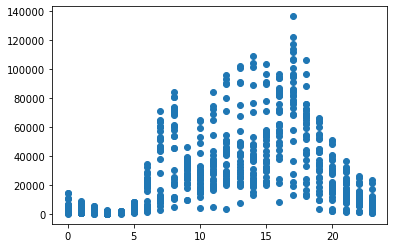

In [82]:
# Step 1: training data

X = x
Y = y

X = np.asarray(X)
Y = np.asarray(Y)

X = X[:,np.newaxis]
Y = Y[:,np.newaxis]

plt.scatter(X,Y)

In [97]:
def errors(d):
    polynomial_features = PolynomialFeatures(degree = d)
    X_TRANSF = polynomial_features.fit_transform(X)
    model = LinearRegression()
    model.fit(X_TRANSF, Y)
    Y_NEW = model.predict(X_TRANSF)
    rmse = np.sqrt(mean_squared_error(Y,Y_NEW))
    print('RMSE: ', rmse)
    print("MSE: ",mean_squared_error(Y,Y_NEW))
    r2 = r2_score(Y,Y_NEW)
    print('R2: ', r2)
    


In [94]:
errors(11)

RMSE:  17970.943648033626
MSE:  322954815.6008001
R2:  0.5809314459185795


In [95]:
errors(6)

RMSE:  18923.91906985295
MSE:  358114712.96234405
R2:  0.5353077034097625


In [98]:
from sklearn.model_selection import train_test_split

In [99]:
# split the data with 70-30% split as above
x_train, x_test, y_train, y_test = train_test_split(feature_data["start_hour"], feature_data["trips"], test_size=0.3,random_state=42)

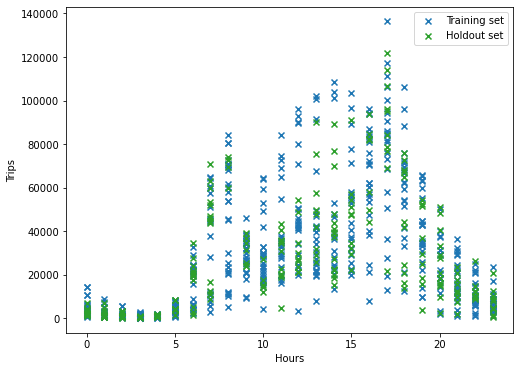

In [101]:
plt.figure(figsize = (8,6))
plt.scatter(x_train, y_train, marker='x', color="C0")
plt.scatter(x_test, y_test, marker='x', color="C2")
plt.xlabel("Hours")
plt.ylabel("Trips")
plt.legend(['Training set', 'Holdout set'])
plt.show()